In [1]:
!pip install numpy==1.23.5

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# To load the 'combined_data_1' dataset
dataset = pd.read_csv('/content/drive/MyDrive/Netflix Project/combined_data_1.txt',header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_Id  object 
 1   Rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [5]:
#To print the head of dataset
dataset.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
#To inspect the shape of the dataset
dataset.shape

(24058263, 2)

In [7]:
#To find the distribution of different ratings in the dataset
ratings_distribution = dataset.groupby('Rating').agg(['count'])

In [8]:
ratings_distribution

,Cust_Id
,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [9]:
# get movie count by counting nan values
movie_count = dataset.isnull().sum()[1]
movie_count
#4499 total number of movies present in dataset

<ipython-input-9-d25b137296d5>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = dataset.isnull().sum()[1]


4499

In [10]:
# get customer count
customer_count = dataset['Cust_Id'].nunique() - movie_count
customer_count

470758

In [11]:
ratings_count = dataset['Cust_Id'].count() - movie_count
ratings_count

24053764

Text(0.5, 1.0, 'Total pool: 4499 Movies, 470758 customers, 24053764 ratings given')

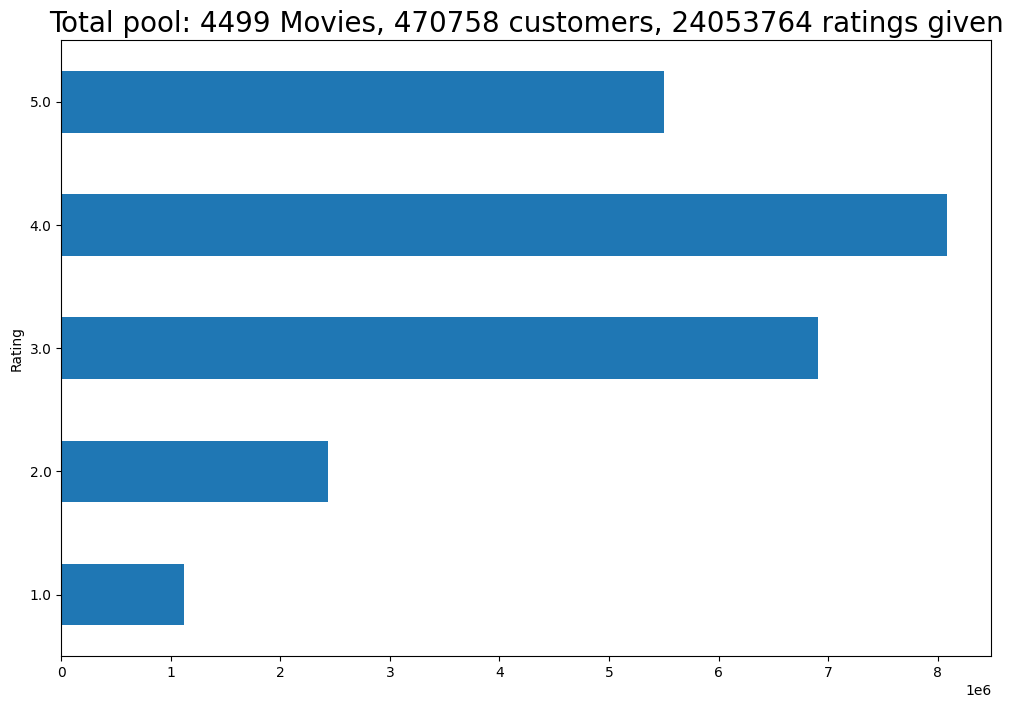

In [12]:
# To plot the distribution of the ratings in as a bar plo
ax = ratings_distribution.plot(kind = 'barh', legend = False, figsize = (12,8))
plt.title(f'Total pool: {movie_count} Movies, {customer_count} customers, {ratings_count} ratings given', fontsize=20)

# **Data Preprocessing**

In [13]:
# To count all the 'nan' values in the Ratings column in the 'ratings' dataset
df_nan = pd.DataFrame(pd.isnull(dataset.Rating))

df_nan.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [14]:
# To store the index of all the rows containing 'nan' values
df_nan = df_nan[df_nan['Rating'] == True]
df_nan.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [15]:
# To reset the index of the dataframe
df_nan.reset_index(inplace=True)
df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [16]:
# To create a numpy array containing movie ids corresponding to the rows in the 'ratings' dataset
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
  temp = np.full((1, i-j-1), movie_id)
  movie_np = np.append(movie_np, temp)
  movie_id += 1

last_record = np.full((1, len(dataset) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [17]:
#To append the above created array to the dataset after removing the 'nan' rows
dataset = dataset[pd.notnull(dataset['Rating'])]
dataset.loc[:, 'Movie_Id'] = movie_np.astype('int')
dataset.loc[:, 'Cust_Id'] = dataset['Cust_Id'].astype('int')
dataset.head()

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [18]:
dataset.shape

(24053764, 3)

# **Data Cleaning**

In [19]:
#To create a list of all the movies rated less often(only include top 30% rated movies)
dataset_movie_summary = dataset.groupby('Movie_Id')['Rating'].agg(['count'])
dataset_movie_summary.head()

,count
Movie_Id,
1,547
2,145
3,2012
4,142
5,1140


In [20]:
dataset_movie_summary.index = dataset_movie_summary.index.map(int)

In [21]:
movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7), 0)

In [22]:
movie_benchmark

1799.0

In [23]:
drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index
print(f'Movie minimum times of review: {movie_benchmark}')

Movie minimum times of review: 1799.0


In [24]:
#To create a list of all the inactive users(users who rate less often)
dataset_cust_summary = dataset.groupby('Cust_Id')['Rating'].agg(['count'])
dataset_cust_summary.index = dataset_cust_summary.index.map(int)
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7), 0)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index
print(f'Movie minimum times of review: {cust_benchmark}')

Movie minimum times of review: 52.0


In [25]:
print(f'Original Shape: {dataset.shape}')

Original Shape: (24053764, 3)


In [26]:
dataset = dataset[~dataset['Movie_Id'].isin(drop_movie_list) & ~dataset['Cust_Id'].isin(drop_cust_list)]
print(f'After Trim Shape: {dataset.shape}')

After Trim Shape: (17337458, 3)


In [27]:
dataset.head()

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [28]:
# Create ratings matrix for 'ratings' matrix with Rows = userId, Columns = movieId
ratings_matrix = pd.pivot_table(dataset, values='Rating', index='Cust_Id', columns='Movie_Id')
ratings_matrix.head()

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
ratings_matrix.shape

(143458, 1350)

In [30]:
# To load the movie_titles dataset
df_titles = pd.read_csv('/content/drive/MyDrive/Netflix Project/movie_titles.csv', encoding = 'ISO-8859-1', header = None, usecols=[0,1,2],names = ['Movie_Id', 'Year', 'Name'])
df_titles.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# **Model Building**

In [31]:
# To install the scikit-surprise library for implementing SVD
! pip install scikit-surprise

In [32]:
# Import required libraries
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [33]:
reader = Reader()

In [34]:
# get just top 100K rows for faster run time
data = Dataset.load_from_df(dataset[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

In [35]:
model = SVD()

In [36]:
cross_validate(model, data, measures=['RMSE'], cv=5)

{'test_rmse': array([0.99782643, 0.9856659 , 1.00297079, 0.99546669, 1.00012913]),
 'fit_time': (2.9928877353668213,
  5.998986482620239,
  4.22461199760437,
  6.277836799621582,
  4.285102128982544),
 'test_time': (0.27061009407043457,
  0.17679667472839355,
  0.33937668800354004,
  0.4801783561706543,
  0.6439878940582275)}

In [37]:
def mape(predictions):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    true_values = np.array([pred.r_ui for pred in predictions])  # Actual ratings
    predicted_values = np.array([pred.est for pred in predictions])  # Predicted ratings
    mape_value = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mape_value

In [38]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2)
predictions = model.test(testset)

# Calculate MAPE for these predictions
print("MAPE:", mape(predictions))

MAPE: 22.702625548297675


# **Recommendation**

In [39]:
dataset

,Cust_Id,Rating,Movie_Id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056841,520675,3.0,4496
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056845,1559566,3.0,4496


In [40]:
df_titles.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [41]:
user_822109 = df_titles.copy() # making copy for individual customer for the recommendation
user_822109

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [42]:
user_822109 = user_822109[~user_822109['Movie_Id'].isin(drop_movie_list)]
user_822109

,Movie_Id,Year,Name
2,3,1997.0,Character
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
16,17,2005.0,7 Seconds
17,18,1994.0,Immortal Beloved
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [43]:
user_822109['Estimate_Score'] = user_822109['Movie_Id'].apply(lambda x: model.predict(822109, x).est)
user_822109

<ipython-input-43-26b7319ed69a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_822109['Estimate_Score'] = user_822109['Movie_Id'].apply(lambda x: model.predict(822109, x).est)


,Movie_Id,Year,Name,Estimate_Score
2,3,1997.0,Character,3.663334
7,8,2004.0,What the #$*! Do We Know!?,3.235944
15,16,1996.0,Screamers,3.118694
16,17,2005.0,7 Seconds,2.963178
17,18,1994.0,Immortal Beloved,3.792332
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,3.601088
17766,17767,2004.0,Fidel Castro: American Experience,3.601088
17767,17768,2000.0,Epoch,3.601088
17768,17769,2003.0,The Company,3.601088


In [44]:
user_822109.sort_values(by='Estimate_Score', ascending=False)

,Movie_Id,Year,Name,Estimate_Score
17,18,1994.0,Immortal Beloved,3.792332
27,28,2002.0,Lilo and Stitch,3.751900
29,30,2003.0,Something's Gotta Give,3.670432
2,3,1997.0,Character,3.663334
12895,12896,1994.0,Bullets Over Broadway,3.601088
...,...,...,...,...
17769,17770,2003.0,Alien Hunter,3.601088
7,8,2004.0,What the #$*! Do We Know!?,3.235944
15,16,1996.0,Screamers,3.118694
16,17,2005.0,7 Seconds,2.963178


In [45]:
# Top 5 movies recommendation for Customer with Customer_ID=822109
top_5_recommendations = user_822109.sort_values(by='Estimate_Score', ascending=False).head(5)
top_5_recommendations

,Movie_Id,Year,Name,Estimate_Score
17,18,1994.0,Immortal Beloved,3.792332
27,28,2002.0,Lilo and Stitch,3.751900
29,30,2003.0,Something's Gotta Give,3.670432
2,3,1997.0,Character,3.663334
12895,12896,1994.0,Bullets Over Broadway,3.601088
